# Overview

 - Runs prediction of specified model on images in samples folder
 - Ensure images added to samples folder have white background with black pen
 - Model architecture defined in models/cnn_base.py
 - Model checkpoint loaded from ocr_letters.pth

In [1]:
import sys
sys.path.append("../")
import torch
import json
from PIL import Image
from torchvision import transforms
from models.cnn_base import CNNBaseModel
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

import wavemix    # Model architecture I was testing -- seems to do better but definitely needs gpu to train
from wavemix.classification import WaveMix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL_CKPT = Path("hanna/model_ckpts/ocr_letters.pth")
MODEL_CKPT = Path("model_ckpts/ocr_wavemix_epoch16.pth")
CLASS_MAP = Path("emnist_letters_map.json")
LETTERS_DIR = Path("samples/inverted_letters/")

with open(str(CLASS_MAP), 'r') as file:
    class_map = json.load(file)

# model = CNNBaseModel()
model = WaveMix(
    num_classes= 27, 
    depth= 16,
    mult= 2,
    ff_channel= 192,
    final_dim= 112,
    dropout= 0.5,
    level=1,
    patch_size=2,
)


In [2]:

model.load_state_dict(torch.load(str(MODEL_CKPT), map_location=device)) #When loading model from weights make sure it matches the specified architecture
model.eval()

def prep_img_for_model(model, img_path, invert=True):
    """
    img_path is pathlib Path object
    Processes input image (Black pen, white background)
    Returns image tensor formatted for given model
        Resized - 28x28
        Inverted colors
    """
    image = Image.open(str(img_path)).convert('L')
    if invert:
        image = Image.eval(image, lambda x: 255 - x) #Invert colors

    transform = transforms.Compose([    #Resize for model and convert to tensor
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

def get_class(class_num): #Convert model's number prediction to letter prediction
    return class_map[str(class_num - 1)]

### Samples images straight from finger-tracker program

torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])


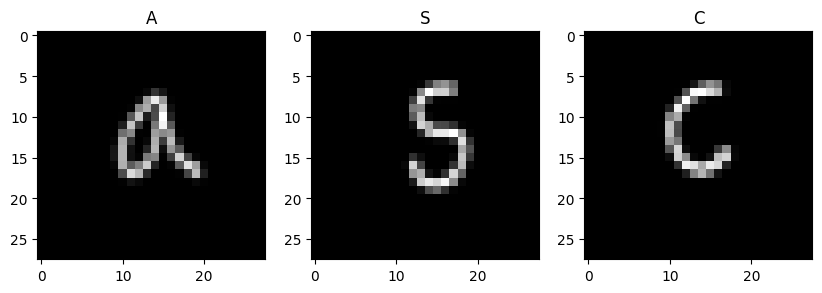

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8)) 

imgs = list(LETTERS_DIR.iterdir())
for i in range(3):
    img = imgs[i]
    img = prep_img_for_model(model, str(img), invert=False)
    axs[i].imshow(img.squeeze(0).squeeze(0), cmap='gray')
    
    if isinstance(model, WaveMix):
        image_tensor_input = img.repeat(1,3,1,1)
    else:
        image_tensor_input = img
    
    print(image_tensor_input.shape)
    
    image_tensor_input = image_tensor_input * 2 - 1 #Normalization Sorta
    output = model(image_tensor_input)
    _, predicted_class = torch.max(output, 1)

    axs[i].set_title(class_map[str(predicted_class.item() - 1)])


plt.show()



### Evaluation Notes

 - Below code generates evaluation diagram by displaying the predictions above each letter
 - Left most letter is highest confidence, the right side ones are lower confidence

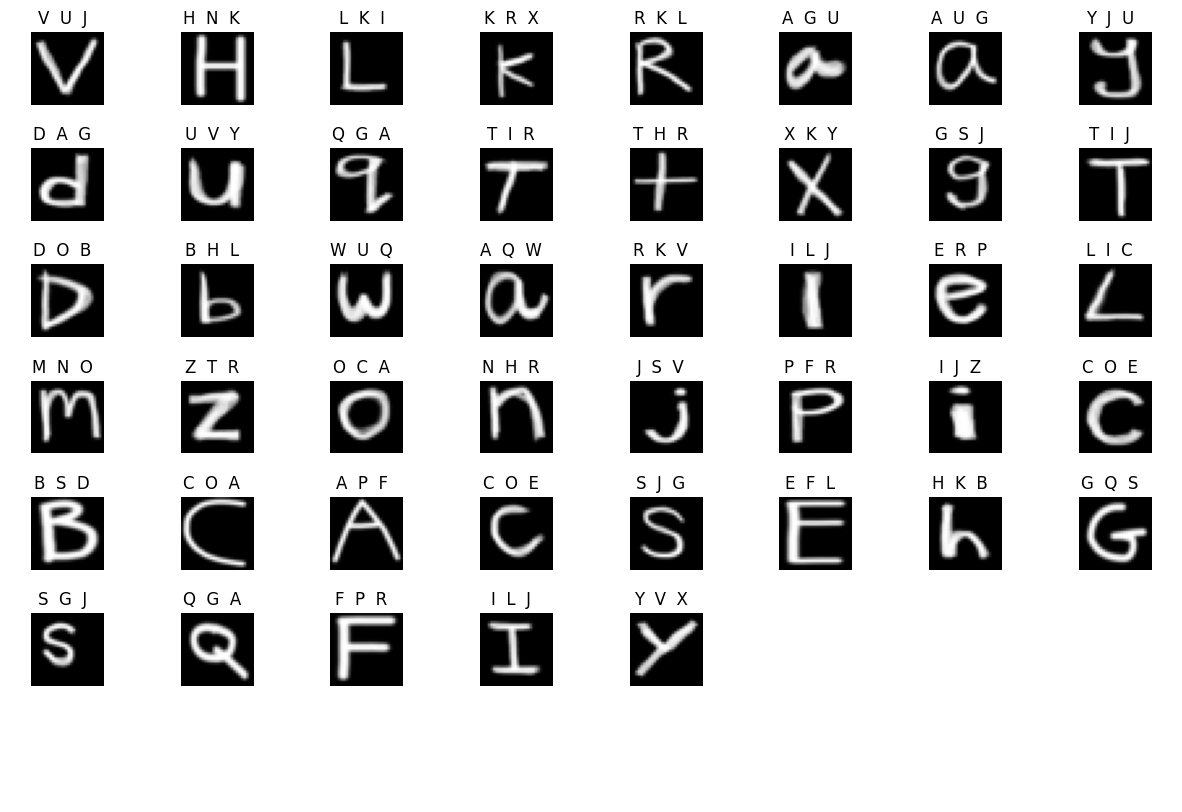

In [4]:
LETTERS_DIR = Path("samples/letters/")
fig, axs = plt.subplots(7, 8, figsize=(15, 10))  # Grid size 7x8
plt.subplots_adjust(hspace=0.6, wspace=0.3)  # Increase space between rows and columns

for ind, img in enumerate(LETTERS_DIR.iterdir()):
    if ind >= 54:  # Limit the number of images to 54
        break
    
    image_tensor = prep_img_for_model(model, str(img))

    if isinstance(model, WaveMix):
        image_tensor_input = image_tensor.repeat(1,3,1,1)
    else:
        image_tensor_input = image_tensor

    image_tensor_input = image_tensor_input * 2 - 1 #Normalize image for model
    with torch.no_grad():
        output = model(image_tensor_input)
    _, predicted_class = torch.max(output, 1)

    _, top3 = torch.topk(output, 3)
    top3 = top3.flatten().tolist()

    top3_preds = ''
    for pred in top3:
        top3_preds += f"{get_class(pred)}  "

    axs[ind // 8, ind % 8].imshow(image_tensor.squeeze(0).squeeze(0), cmap='gray')
    axs[ind // 8, ind % 8].set_title(top3_preds)
    axs[ind // 8, ind % 8].axis('off')  # Optional: Turn off axis for cleaner look

# Hide unused subplots if there are fewer images than grid spaces (2 empty spots)
for ax in axs.flatten()[ind+1:]:
    ax.axis('off')

plt.show()